In [2]:
import os 
import numpy as np
import matplotlib.pyplot as plt 

In [3]:
import torch 
import torch.utils.data
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import init
from torchvision import datasets, transforms, models, utils
from tqdm import tqdm

## CNN for MNIST

In [4]:
#Training params 
batch_size = 64 
num_epochs = 10
learning_rate = 0.01
dropout_p = 0.5
log_interval = 10
num_hidden_units = 50 
num_classes = 10 
image_size = 28

In [5]:
#Train Data Loaders 
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST("data/mnist", train=True, download=True,
                  transform=transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize((0.1307,),(0.3081,))
                  ])),
    batch_size=batch_size,shuffle=True)

Processing...
Done!


In [6]:
#Test Data Loaders 
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST("data/mnist", train=False,
                   transform=transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize((0.1307,),(0.3081,))
                  ])),
    batch_size=batch_size,shuffle=True)

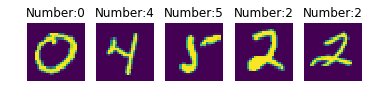

In [7]:
#Visualize some examples
batch = next(iter(test_loader))
samples = batch[0][:5]
y_true = batch[1]
for i, sample in enumerate(samples):
    plt.subplot(1,5,i+1)
    plt.title("Number:%i" % y_true[i])
    plt.imshow(sample.numpy().reshape((28,28)))
    plt.axis("off")

In [8]:
#CNN model
class CNN(nn.Module):
    def __init__(self, dropout_p,num_hidden_units,num_classes):
        super(CNN,self).__init__()
        self.conv1=nn.Conv2d(1,10,kernel_size=5)
        self.conv2 = nn.Conv2d(10,20,kernel_size=5)
        self.dropout_conv2=nn.Dropout2d(dropout_p)
        self.fc1 = nn.Linear(320,num_hidden_units)
        self.fc2 = nn.Linear(num_hidden_units, num_classes)
        
    def forward(self,x):
        x=F.relu(F.max_pool2d(self.conv1(x),2))
        x= F.relu(F.max_pool2d(self.dropout_conv2(self.conv2(x)),2))
        x=x.view(-1,320)
        x=F.relu(self.fc1(x))
        x=F.dropout(x,training=self.training)
        x=self.fc2(x)
        return x

In [9]:
#Initialize model components 
model = CNN(dropout_p,num_hidden_units,num_classes)
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [10]:
from sklearn.metrics import classification_report

In [11]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [12]:
example_data.shape

torch.Size([64, 1, 28, 28])

In [13]:
data_size=len(train_loader.dataset)
num_batches = data_size//batch_size

In [15]:
def train():
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        epoch_acc = 0
        for X, y in tqdm(train_loader):
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() 
            predictions = torch.argmax(out, 1)
            epoch_acc += torch.sum(predictions==y).item()
        epoch_loss = epoch_loss/num_batches
        epoch_acc = epoch_acc/data_size
        print(f"Epoch {epoch}:")
        print("ACC:", epoch_acc, "LOSS:", epoch_loss)
        #In the 2 lines below we save our model and optimizer,
        #in order to load them again in the future. 
        #Just write your path inside "". 
        torch.save(model.state_dict(), "trained/model.pth")
        torch.save(optimizer.state_dict(),'trained/optimizer.pth')
if __name__ == "__main__": 
    train()

In [1]:
state_dict1 = torch.load("trained/model.pth")
state_dict2 = torch.load("trained/optimizer.pth")
model.load_state_dict(state_dict1)
optimizer.load_state_dict(state_dict2)
def test():
    model.eval()
    acc = 0
    y_hat = []
    y_true = []
    for X, y in tqdm(test_loader.dataset):
        out = model(X)
        predictions = torch.argmax(out, 1)
        acc += torch.sum(predictions == y).item()
        y_hat.append(predictions)
        y_true.append(y)

    y_hat = torch.cat(y_hat)
    y_true = torch.cat(y_true)
    acc = acc/len(test_loader.dataset)
    print(acc)
    print(classification_report(y_hat, y_true))


if __name__ == "__main__":
    test()